<a href="https://colab.research.google.com/github/shubhamdasmohapatraa/eye-diseases-detection-using-dll/blob/main/eye_disease_mobilenetv2_model_se_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

100%|██████████| 736M/736M [00:05<00:00, 129MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


In [ ]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load dataset
train_dir = '/kaggle/input/eye-diseases-classification/dataset'

# Load training dataset without preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    shuffle=True,
)

# Load validation dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(256, 256),
    seed=42,
)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [ ]:
# Get the class names from the subdirectories in the training directory
class_names = sorted(os.listdir(train_dir))

# Print the class names and the number of classes
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of Classes: 4


In [ ]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image and resize
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


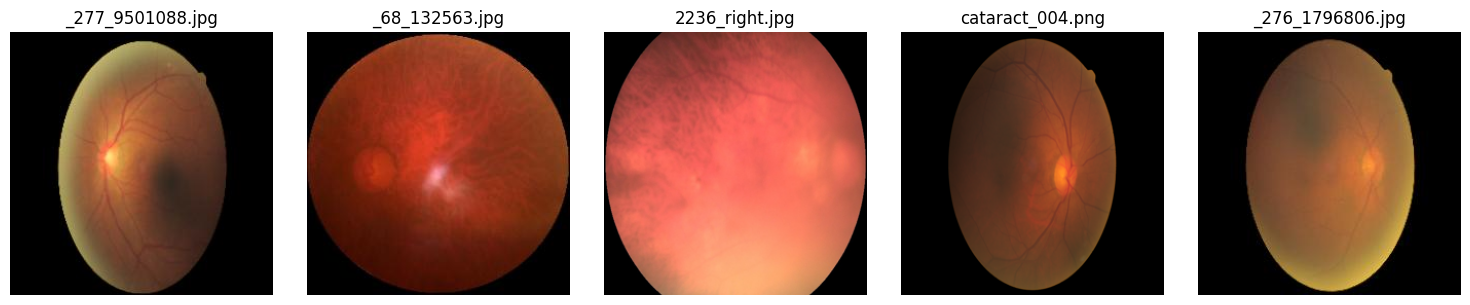

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/kaggle/input/eye-diseases-classification/dataset/cataract"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

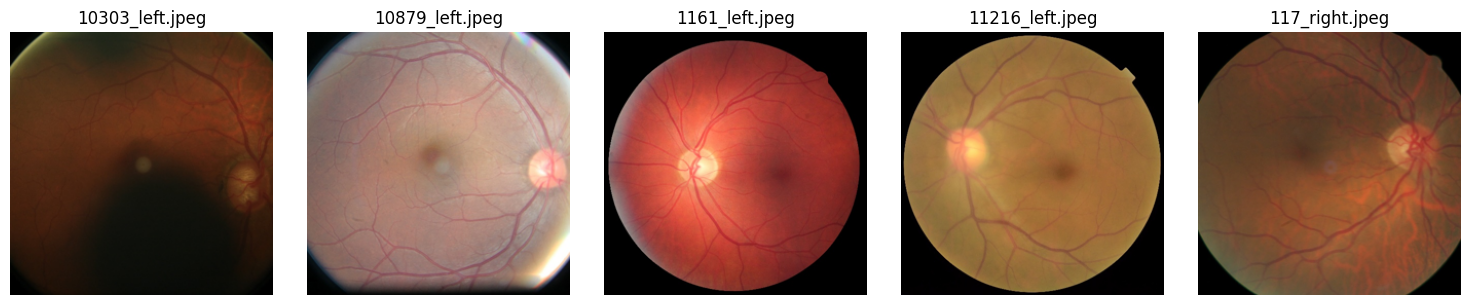

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

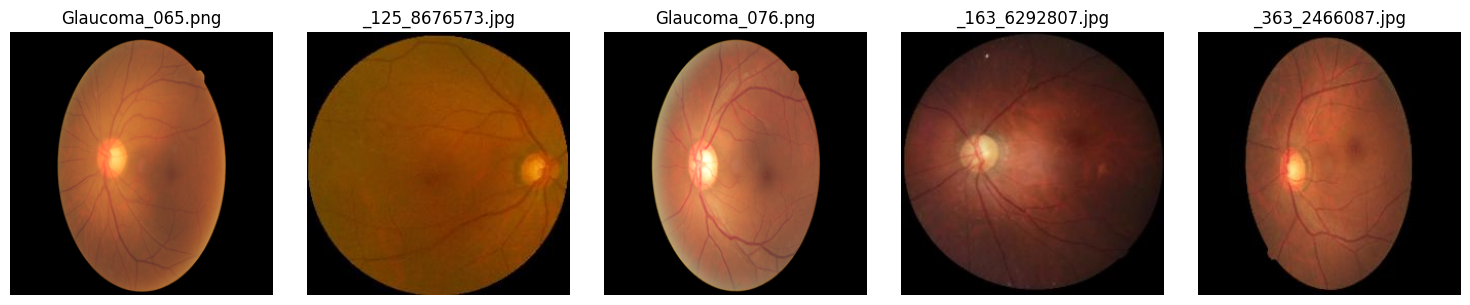

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/kaggle/input/eye-diseases-classification/dataset/glaucoma"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

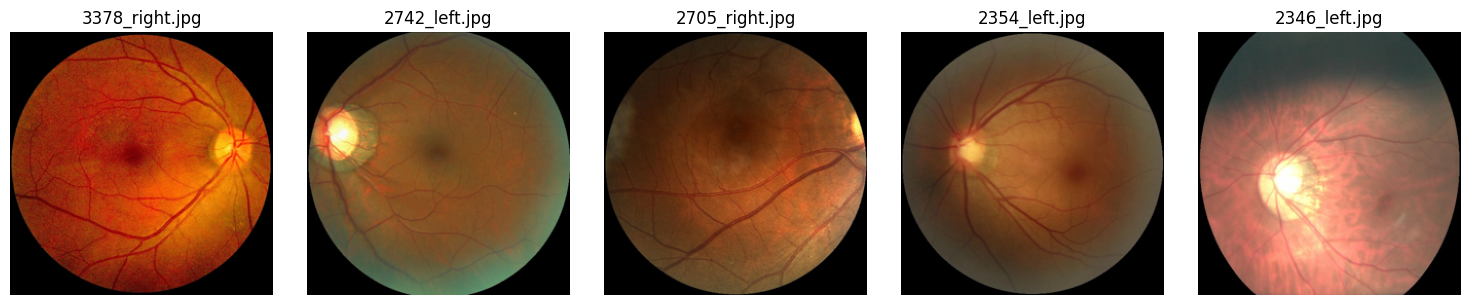

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/kaggle/input/eye-diseases-classification/dataset/normal"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte

# === Paths ===
input_root = '/kaggle/input/eye-diseases-classification/dataset'                  # Your input dataset path
output_root = '/content/filtered_images_1'        # Where to save filtered images
output_format = 'RGB'                   # Choose between "RGB" or "HSV"

# Create output directory if it doesn't exist
os.makedirs(output_root, exist_ok=True)

# === Walk through subdirectories ===
for subdir, _, files in os.walk(input_root):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            input_path = os.path.join(subdir, file)

            # Create corresponding output directory
            relative_path = os.path.relpath(subdir, input_root)
            output_dir = os.path.join(output_root, relative_path)
            os.makedirs(output_dir, exist_ok=True)

            # === Step 1: Load image and convert to RGB ===
            bgr_img = cv2.imread(input_path)
            if bgr_img is None:
                print(f"Skipped (couldn't read): {input_path}")
                continue

            rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

            # === Step 2: Apply Gaussian Blur ===
            blurred_img = cv2.GaussianBlur(rgb_img, (5, 5), 0)

            # === Step 3: Apply Non-local Means Denoising ===
            float_img = blurred_img.astype(np.float32) / 255.0
            sigma = np.mean(estimate_sigma(float_img, channel_axis=-1))
            denoised = denoise_nl_means(float_img, h=1.15 * sigma, fast_mode=True,
                                        patch_size=5, patch_distance=3, channel_axis=-1)
            denoised_uint8 = img_as_ubyte(denoised)

            # === Step 4: Convert to HSV if needed ===
            if output_format.upper() == "HSV":
                final_img = cv2.cvtColor(denoised_uint8, cv2.COLOR_RGB2HSV)
            else:
                final_img = denoised_uint8

            # === Step 5: Save filtered image ===
            filename = os.path.basename(file)
            output_path = os.path.join(output_dir, filename)

            # Convert to BGR before saving (for compatibility)
            if output_format.upper() == "RGB":
                save_img = cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR)
            else:  # HSV to BGR
                save_img = cv2.cvtColor(final_img, cv2.COLOR_HSV2BGR)

            cv2.imwrite(output_path, save_img)
            print(f"Saved: {output_path}")

print("\n All images processed and saved with filters.")


Saved: /content/filtered_images_1/glaucoma/1255_right.jpg
Saved: /content/filtered_images_1/glaucoma/1482_left.jpg
Saved: /content/filtered_images_1/glaucoma/_398_8823411.jpg
Saved: /content/filtered_images_1/glaucoma/_309_4110303.jpg
Saved: /content/filtered_images_1/glaucoma/_13_697490.jpg
Saved: /content/filtered_images_1/glaucoma/_205_310538.jpg
Saved: /content/filtered_images_1/glaucoma/Glaucoma_040.png
Saved: /content/filtered_images_1/glaucoma/1256_right.jpg
Saved: /content/filtered_images_1/glaucoma/_221_3079640.jpg
Saved: /content/filtered_images_1/glaucoma/_392_9636183.jpg
Saved: /content/filtered_images_1/glaucoma/_12_5295071.jpg
Saved: /content/filtered_images_1/glaucoma/_399_7128170.jpg
Saved: /content/filtered_images_1/glaucoma/_113_8738972.jpg
Saved: /content/filtered_images_1/glaucoma/_366_3572426.jpg
Saved: /content/filtered_images_1/glaucoma/_43_2637980.jpg
Saved: /content/filtered_images_1/glaucoma/Glaucoma_052.png
Saved: /content/filtered_images_1/glaucoma/Glaucoma_

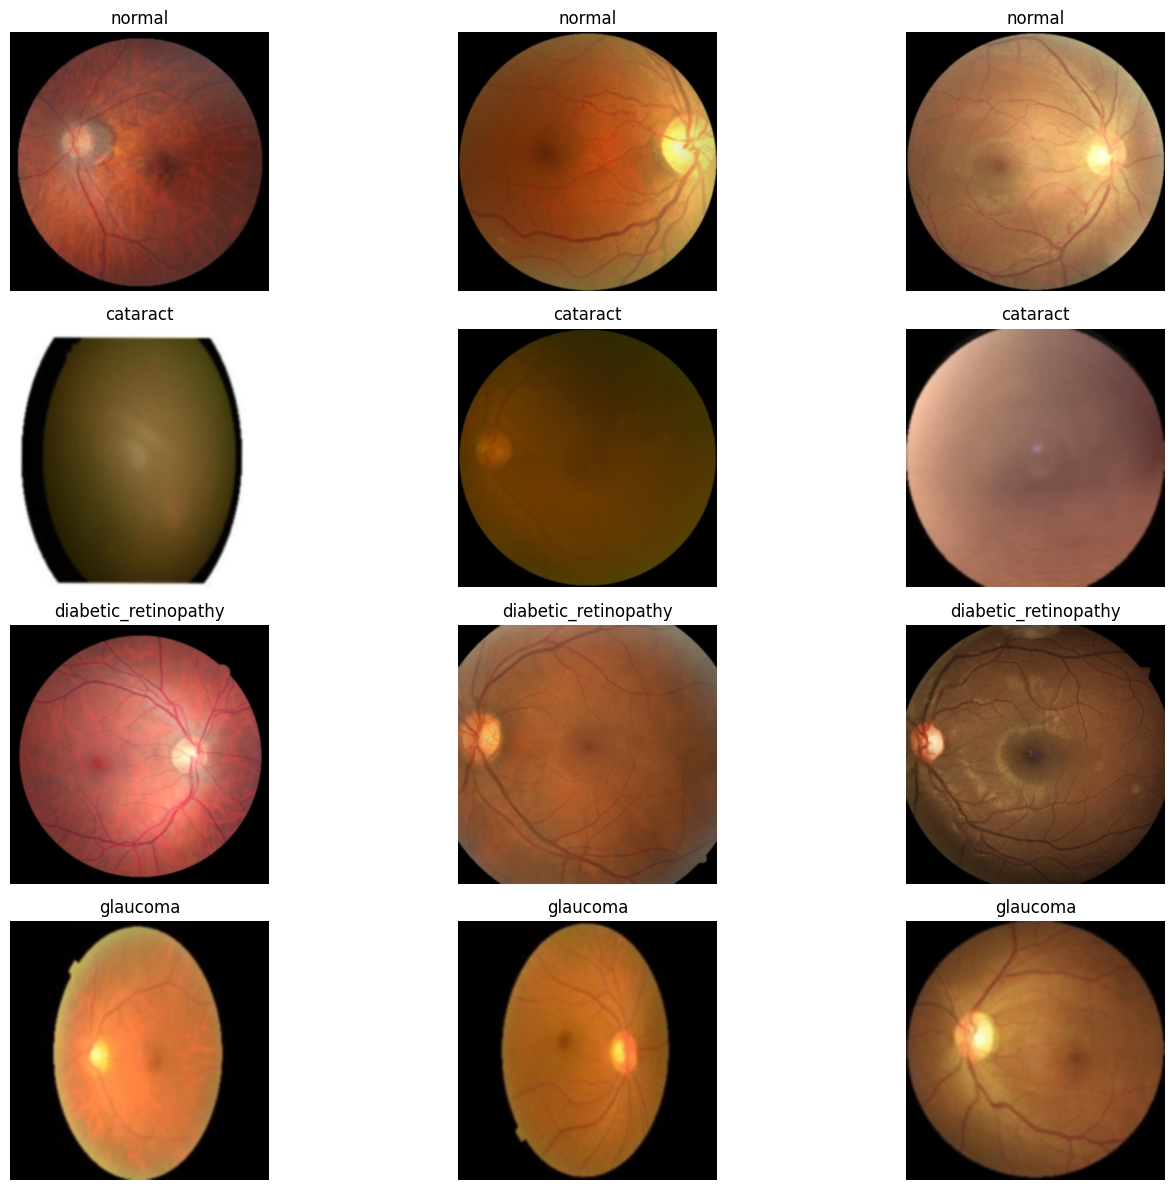

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# === Configuration ===
dataset_path = '/content/filtered_images_1'          # Path to your dataset
classes = os.listdir(dataset_path)
images_per_class = 3              # Number of images to display per class

# === Plot Setup ===
total_classes = len(classes)
plt.figure(figsize=(15, total_classes * 3))

img_count = 1

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for i in range(min(images_per_class, len(image_files))):
        image_path = os.path.join(class_path, image_files[i])
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(total_classes, images_per_class, img_count)
        plt.imshow(img_rgb)
        plt.title(class_name)
        plt.axis('off')
        img_count += 1

plt.tight_layout()
plt.show()


In [ ]:
# for faster training which takes less time and less memory for training  batch size
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Augmentation for training dataset              prevent overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.5)
])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# === DATA LOADING ===
train_dir = '/content/filtered_images_1'
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

# === DATA PREPROCESSING ===
AUTOTUNE = tf.data.AUTOTUNE
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

# === TRANSFER LEARNING MODEL ===
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze all layers

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# === COMPILE MODEL ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === TRAIN MODEL ===
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# === EVALUATE MODEL ===
test_loss, test_acc = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy: {test_acc:.4f}")


Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - accuracy: 0.5580 - loss: 3.2237 - val_accuracy: 0.8149 - val_loss: 2.4674
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7994 - loss: 2.4006 - val_accuracy: 0.8434 - val_loss: 2.0908
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8389 - loss: 2.0369 - val_accuracy: 0.8577 - val_loss: 1.8170
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8540 - loss: 1.7658 - val_accuracy: 0.8660 - val_loss: 1.6073
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8677 - loss: 1.5567 - val_accuracy: 0.8743 - val_loss: 1.4452
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8836 - loss: 1.3926 - val_accuracy: 0.8766 - val_loss: 1.3150
Epoch 7/10
106/106 ━━━━━━━━━━━

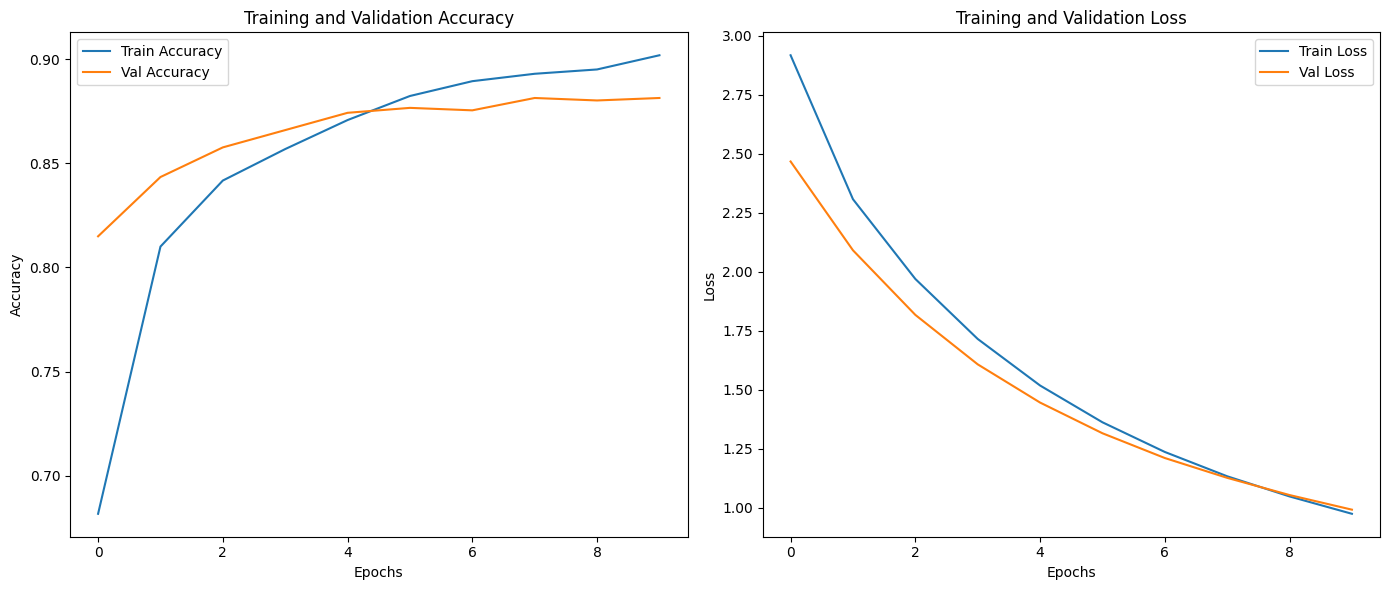

In [ ]:
import matplotlib.pyplot as plt

# === PLOT TRAINING HISTORY ===
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# === CALL FUNCTION TO PLOT ===
plot_training_history(history)


In [ ]:
# After training
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Accuracy: 0.9019
Final Validation Accuracy: 0.8814


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Step 1: Unfreeze deeper layers for fine-tuning ===
base_model.trainable = True

# Freeze first 'n' layers (e.g., first 100) to avoid overfitting
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# === Step 2: Recompile with a lower learning rate ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',  # or categorical_crossentropy if using one-hot
    metrics=['accuracy']
)

# === Step 3: Add callbacks ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# === Step 4: Fine-tuning ===
fine_tune_epochs = 20
total_epochs = len(history.history['loss']) + fine_tune_epochs

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=len(history.history['loss']),
    callbacks=[early_stop, reduce_lr]
)


Epoch 11/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - accuracy: 0.6400 - loss: 1.7131 - val_accuracy: 0.8505 - val_loss: 1.0387 - learning_rate: 1.0000e-05
Epoch 12/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8652 - loss: 1.0615 - val_accuracy: 0.8624 - val_loss: 1.0288 - learning_rate: 1.0000e-05
Epoch 13/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9027 - loss: 0.9565 - val_accuracy: 0.8719 - val_loss: 1.0154 - learning_rate: 1.0000e-05
Epoch 14/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9269 - loss: 0.8870 - val_accuracy: 0.8719 - val_loss: 0.9974 - learning_rate: 1.0000e-05
Epoch 15/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9473 - loss: 0.8340 - val_accuracy: 0.8778 - val_loss: 0.9792 - learning_rate: 1.0000e-05
Epoch 16/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9612 - loss: 0.7909 - val_accuracy: 0.8754 - val_loss: 0.9608 - learning_rate: 1.0000e-05
Epoch 17/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/

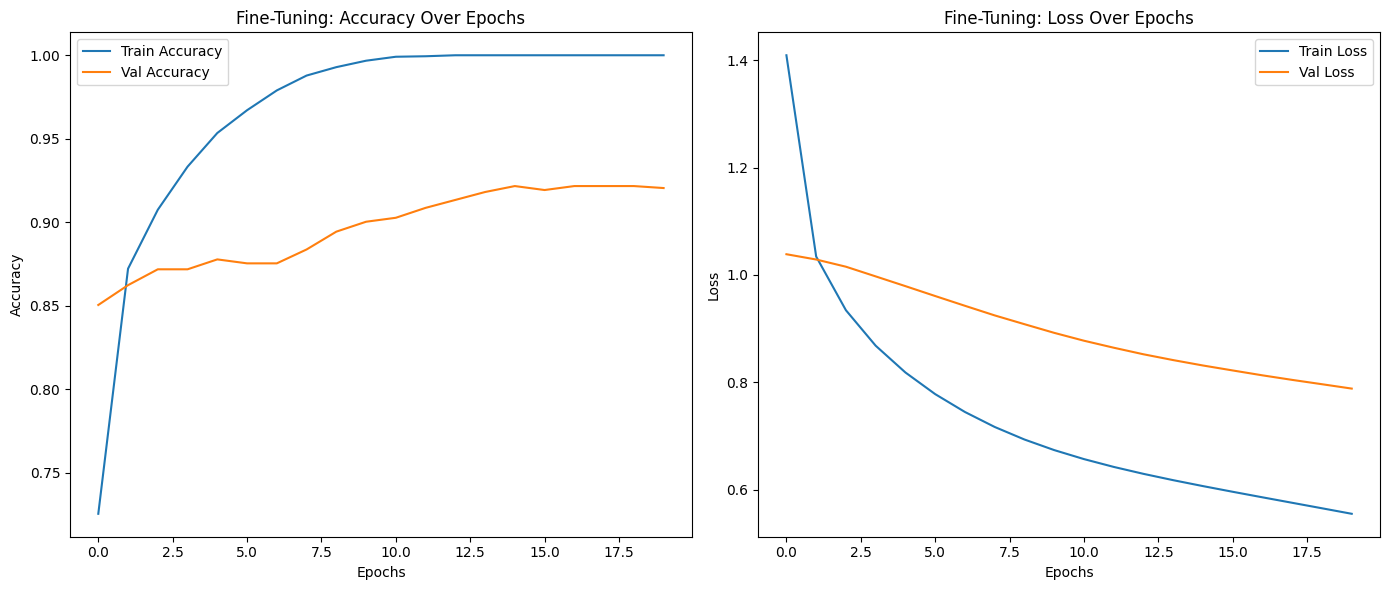

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from fine-tuning history
acc = fine_tune_history.history['accuracy']
val_acc = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']

# Plotting
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Fine-Tuning: Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Fine-Tuning: Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"\nFinal Training Accuracy after Fine-Tuning: {train_accuracy:.4f}")

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Final Validation Accuracy after Fine-Tuning: {val_accuracy:.4f}")


106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9839 - loss: 0.5907

Final Training Accuracy after Fine-Tuning: 0.9843
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9155 - loss: 0.8014
Final Validation Accuracy after Fine-Tuning: 0.9205


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# === SE Block (Squeeze-and-Excitation) ===
def se_block(input_tensor, reduction_ratio=8):
    channel = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channel // reduction_ratio, activation='relu')(se)
    se = layers.Dense(channel, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channel))(se)
    return layers.Multiply()([input_tensor, se])

# === Load MobileNetV2 base model ===
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# === Model architecture ===
inputs = tf.keras.Input(shape=(256, 256, 3))

# Normalization using built-in layer (avoids Lambda issues)
x = layers.Rescaling(scale=1./127.5)(inputs)
x = layers.Lambda(lambda x: x - 1.0, name="rescale_shift")(x)

x = base_model(x)
x = se_block(x)  # Add SE block here

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

num_classes = 4  # Update as needed
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# === Callbacks ===
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# === Data loading ===
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/filtered_images_1',
    image_size=(256, 256),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/filtered_images_1',
    image_size=(256, 256),
    batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/filtered_images_1',
    image_size=(256, 256),
    batch_size=32,
    shuffle=False
)

# === Training ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# === Save model ===
model.save("fine_tuned_cnn_bilstm_se_mobilenetv2.keras", include_optimizer=False)


Found 4217 files belonging to 4 classes.
Found 4217 files belonging to 4 classes.
Found 4217 files belonging to 4 classes.
Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 315ms/step - accuracy: 0.3806 - loss: 1.4997 - val_accuracy: 0.4970 - val_loss: 1.3421 - learning_rate: 1.0000e-05
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 305ms/step - accuracy: 0.6284 - loss: 0.8889 - val_accuracy: 0.5748 - val_loss: 1.2318 - learning_rate: 1.0000e-05
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.7378 - loss: 0.6911 - val_accuracy: 0.6215 - val_loss: 1.0395 - learning_rate: 1.0000e-05
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 305ms/step - accuracy: 0.7985 - loss: 0.5419 - val_accuracy: 0.7204 - val_loss: 0.8018 - learning_rate: 1.0000e-05
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 303ms/step - accuracy: 0.8522 - loss: 0.4251 - val_accuracy: 0.7505 - val_loss: 0.6577 - learning_rate: 1.0000e-05
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 40s 298ms/step - accuracy: 0.8771 - loss: 

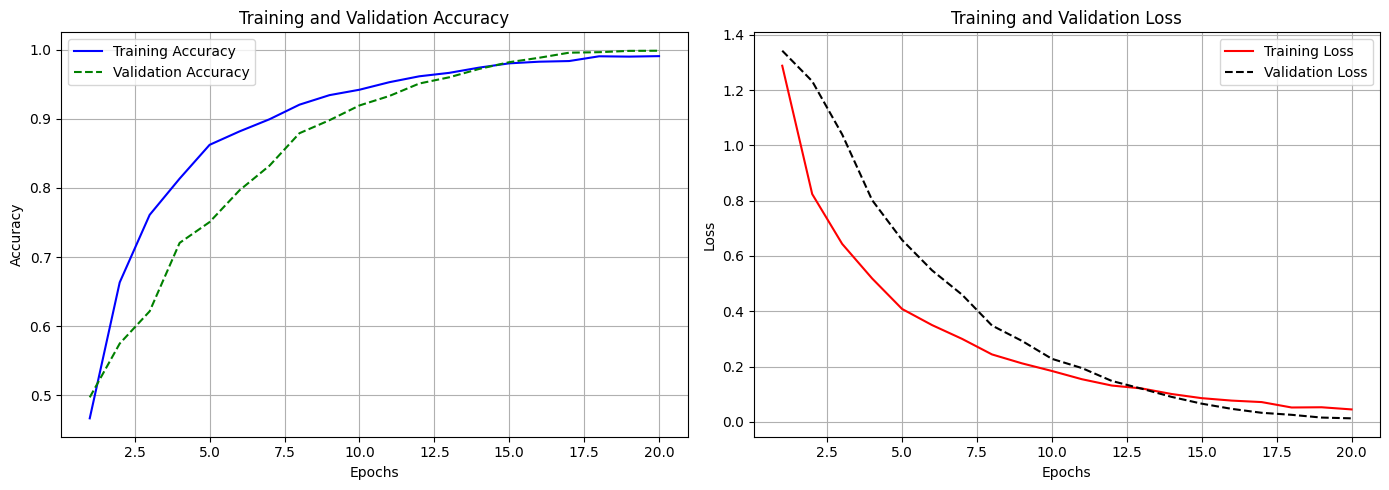

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'k--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this after model training
plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/st

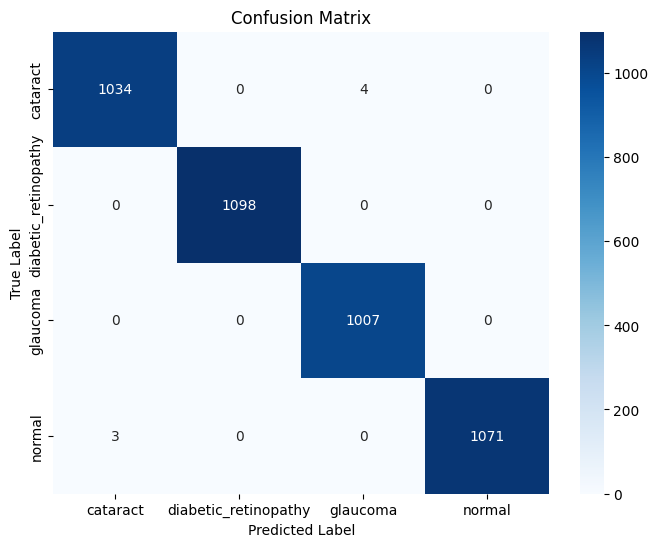

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === Load the model (if not already loaded) ===
model = tf.keras.models.load_model("fine_tuned_cnn_bilstm_se_mobilenetv2.keras")

# === Get class names from dataset ===
class_names = test_ds.class_names

# === Get true labels and predicted labels ===
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# === Classification Report ===
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_single_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = img_array / 127.5 - 1.0  # Same preprocessing
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    print(f"Predicted class: {predicted_class}")

# Example usage
predict_single_image('/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/10003_right.jpeg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted class: diabetic_retinopathy


In [ ]:
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i in range(5):  # Check first 5 images
        actual = class_names[labels[i].numpy()]
        predicted = class_names[np.argmax(predictions[i])]
        print(f"Image {i}: Actual: {actual}, Predicted: {predicted}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Image 0: Actual: cataract, Predicted: cataract
Image 1: Actual: cataract, Predicted: cataract
Image 2: Actual: cataract, Predicted: cataract
Image 3: Actual: cataract, Predicted: cataract
Image 4: Actual: cataract, Predicted: cataract


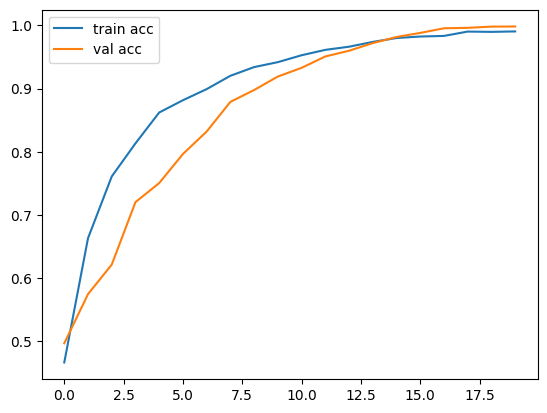

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()


In [ ]:
# === Extract final training and validation accuracy from history ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

# === Evaluate the model on the test dataset ===
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Final Training Accuracy: 99.05%
Final Validation Accuracy: 99.83%
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9971 - loss: 0.0147
Test Accuracy: 99.83%


In [ ]:
predicted_samples = {}
class_names = test_ds.class_names

for images, labels in test_ds:
    predictions = model.predict(images)

    for i in range(len(images)):
        true_label = labels[i].numpy()
        class_name = class_names[true_label]

        if class_name not in predicted_samples:
            predicted_class = class_names[np.argmax(predictions[i])]
            predicted_samples[class_name] = (class_name, predicted_class)

        # Break early if we've got one sample from every class
        if len(predicted_samples) == len(class_names):
            break
    if len(predicted_samples) == len(class_names):
        break

# === Display Predictions per Class ===
print("\nSample Predictions for Each Class:\n")
for actual, predicted in predicted_samples.values():
    print(f"Actual: {actual} | Predicted: {predicted}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

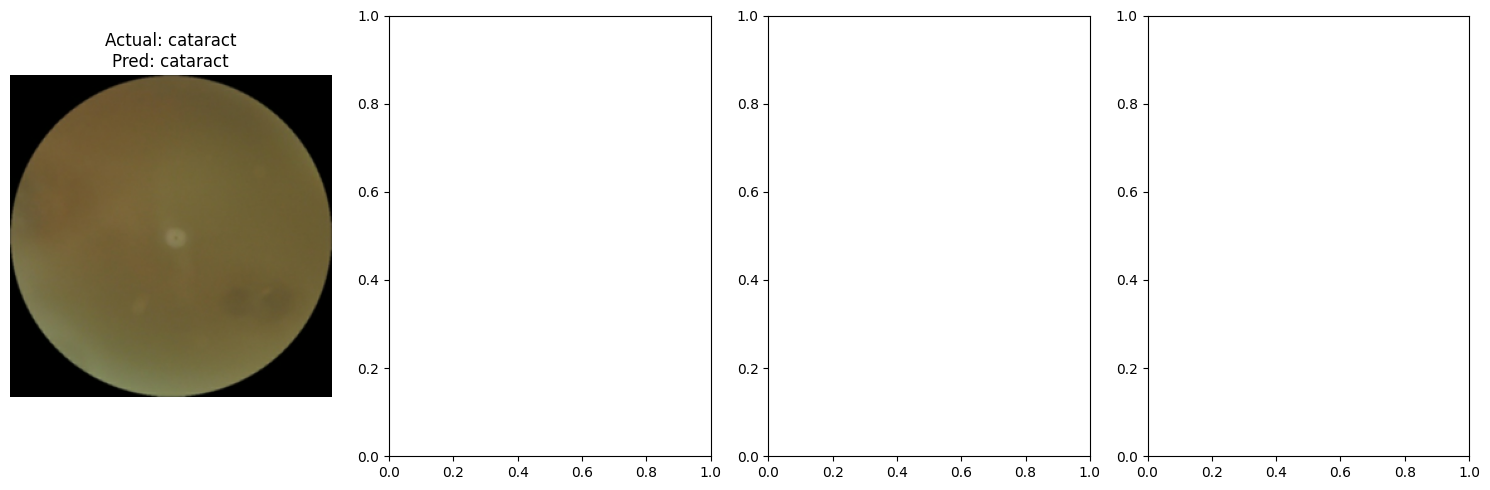

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(predicted_samples), figsize=(15, 5))

for idx, (actual, predicted) in enumerate(predicted_samples.values()):
    for images, labels in test_ds:
        for i in range(len(images)):
            if class_names[labels[i].numpy()] == actual:
                axes[idx].imshow(images[i].numpy().astype("uint8"))
                axes[idx].axis('off')
                axes[idx].set_title(f"Actual: {actual}\nPred: {predicted}")
                break
        break

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

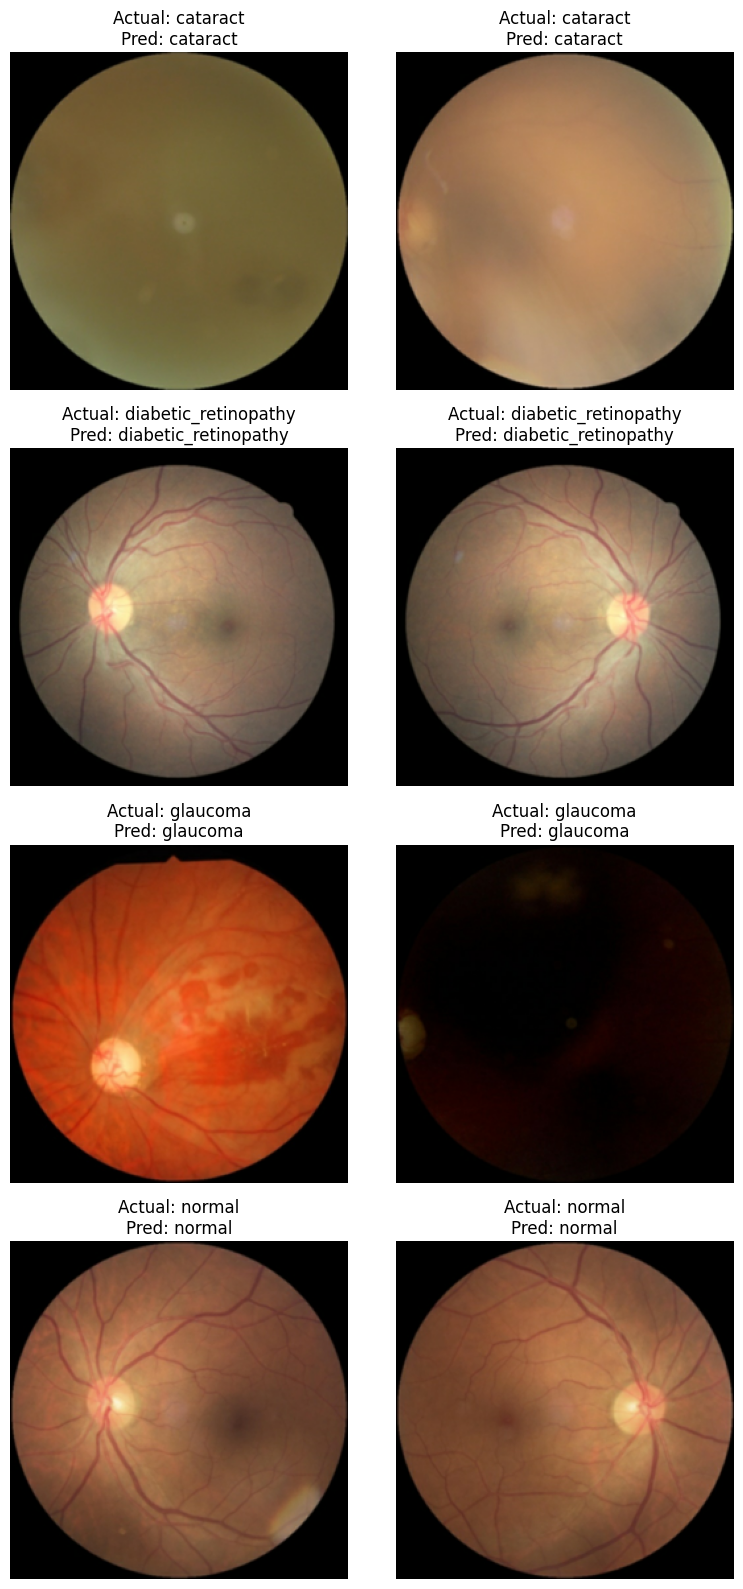

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to hold 2 (actual, predicted, image) tuples per class
predicted_samples = {class_name: [] for class_name in class_names}

# Collect 2 images per class
for images, labels in test_ds:
    predictions = model.predict(images)

    for i in range(len(images)):
        true_label = labels[i].numpy()
        class_name = class_names[true_label]

        # Only add if less than 2 samples already saved
        if len(predicted_samples[class_name]) < 2:
            predicted_class = class_names[np.argmax(predictions[i])]
            predicted_samples[class_name].append((class_name, predicted_class, images[i]))

    # Stop if we have 2 images for every class
    if all(len(samples) == 2 for samples in predicted_samples.values()):
        break

# === Plotting 2 images per class ===
num_classes = len(class_names)
fig, axes = plt.subplots(num_classes, 2, figsize=(8, 4 * num_classes))

for row_idx, class_name in enumerate(class_names):
    for col_idx in range(2):
        actual, predicted, img = predicted_samples[class_name][col_idx]
        ax = axes[row_idx, col_idx] if num_classes > 1 else axes[col_idx]
        ax.imshow(img.numpy().astype("uint8"))
        ax.axis('off')
        ax.set_title(f"Actual: {actual}\nPred: {predicted}")

plt.tight_layout()
plt.show()


In [ ]:
for layer in model.get_layer("mobilenetv2_1.00_224").layers:
    print(layer.name)


input_layer_18
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6

In [ ]:
for layer in model.layers:
    print(layer.name)


input_layer_19
rescaling
rescale_shift
mobilenetv2_1.00_224
global_average_pooling2d_9
dense_34
dense_35
reshape_16
multiply_16
conv2d_24
max_pooling2d_16
conv2d_25
max_pooling2d_17
reshape_17
bidirectional_16
bidirectional_17
batch_normalization_8
dropout_16
dense_36
dropout_17
dense_37


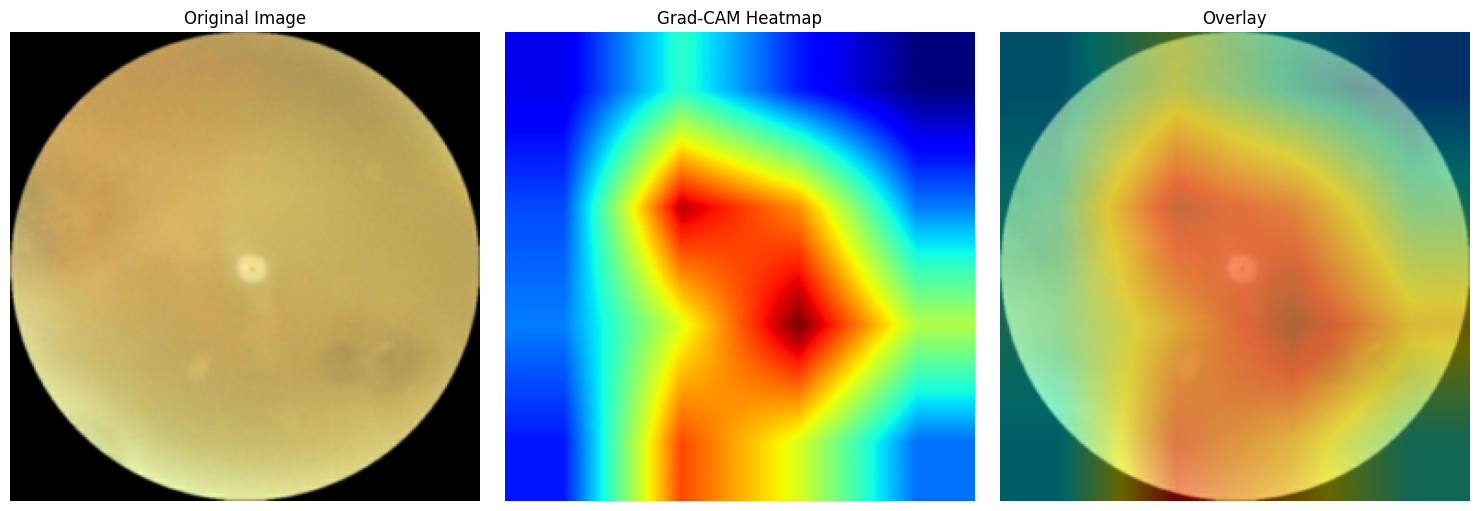

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Grad-CAM heatmap generator
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient of class output w.r.t. conv layer output
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM visualizer
def show_gradcam(img, heatmap, alpha=0.4):
    # Convert tensor to array
    img = tf.keras.utils.array_to_img(img)
    img = np.array(img)

    # Ensure the image has 3 channels
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Normalize image to uint8
    if img.dtype != np.uint8:
        img = np.uint8(255 * img / np.max(img))

    # Resize heatmap to match the image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply the colormap
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)

    # Superimpose the heatmap
    superimposed_img = cv2.addWeighted(img, 1 - alpha, jet, alpha, 0)

    # Plot all three: input image, heatmap, overlay
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `images[0]` is your input image (shape: [H, W, 3]), and `model` is already loaded
img = tf.expand_dims(images[0], axis=0)  # Add batch dimension
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name="conv2d_25")
show_gradcam(images[0], heatmap)


In [ ]:
!pip install lime scikit-image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=df75a096db9c66650b8392b7ea8bd85c9bf272a4d7b4853e51dc23dc751e3fa8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━

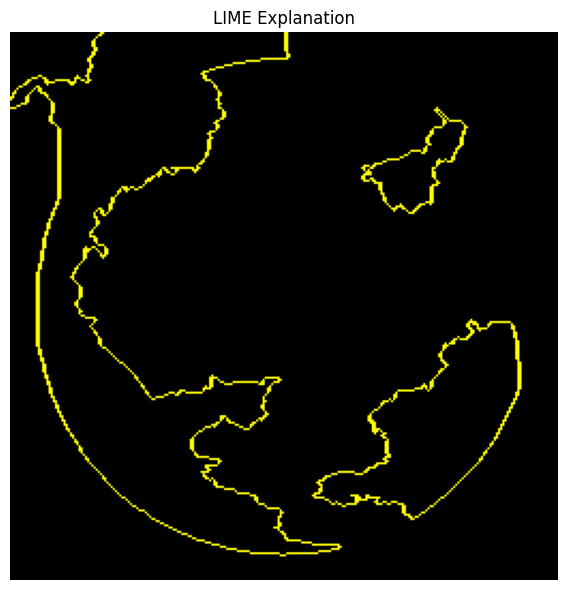

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import cv2

# 1. Load your trained model
model = load_model("/content/fine_tuned_cnn_bilstm_se_mobilenetv2.keras")  # Replace with your model path

# 2. Define image preprocessing
def preprocess_image(img_path, target_size=(256, 256)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize
    return img_array

# 3. Predict function required for LIME
def predict_fn(images):
    images = np.array(images)
    return model.predict(images)

# 4. Load and preprocess the image
image_path = "/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/10007_left.jpeg"  # Replace with your image path
img_array = preprocess_image(image_path)
img_batch = np.expand_dims(img_array, axis=0)

# 5. Initialize LIME
explainer = lime_image.LimeImageExplainer()

# 6. Explain instance
explanation = explainer.explain_instance(
    img_array,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000  # You can increase this for more accurate explanations
)

# 7. Get image and mask for the top class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# 8. Show the explanation
plt.figure(figsize=(6, 6))
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.tight_layout()
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━

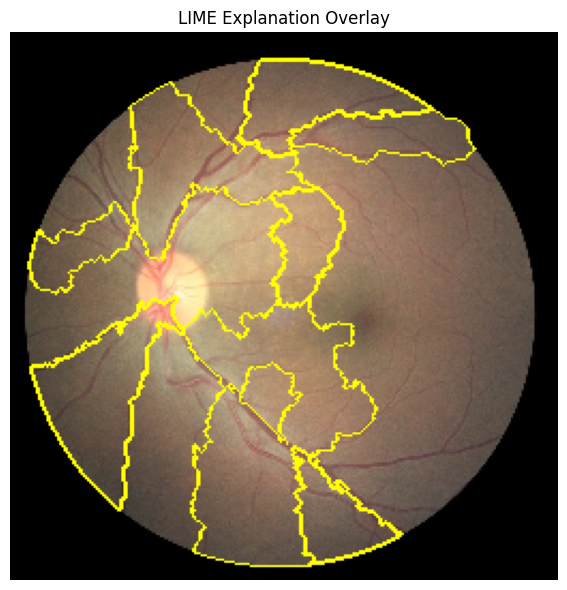

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("/content/fine_tuned_cnn_bilstm_se_mobilenetv2.keras")  # replace with your model path

# Function to preprocess image
def preprocess_image(img_path, target_size=(256, 256)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array.astype('float32') / 255.0  # Normalize
    return img_array, np.expand_dims(img_array, axis=0)

# Path to your retina image
img_path = "/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/10003_left.jpeg"  # Replace with your retina image path
img, img_expanded = preprocess_image(img_path)

# LIME explainer setup
explainer = lime_image.LimeImageExplainer()

# Define prediction function
def predict_fn(images):
    return model.predict(np.array(images))

# Explain instance
explanation = explainer.explain_instance(
    img.astype('double'),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get explanation image and mask
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False
)

# Overlay LIME explanation on the original image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mark_boundaries(img, mask))
ax.set_title("LIME Explanation Overlay")
ax.axis('off')
plt.tight_layout()
plt.show()


Found 4217 files belonging to 4 classes.
132/132 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step

🧾 Classification Report (7 Decimal Precision):

                      precision    recall  f1-score      support
cataract              0.9639376 0.9527938 0.9583333 1038.0000000
diabetic_retinopathy  1.0000000 1.0000000 1.0000000 1098.0000000
glaucoma              0.9441118 0.9394240 0.9417621 1007.0000000
normal                0.9651696 0.9804469 0.9727483 1074.0000000
accuracy              0.9689353 0.9689353 0.9689353    0.9689353
macro avg             0.9683047 0.9681662 0.9682109 4217.0000000
weighted avg          0.9689068 0.9689353 0.9688964 4217.0000000


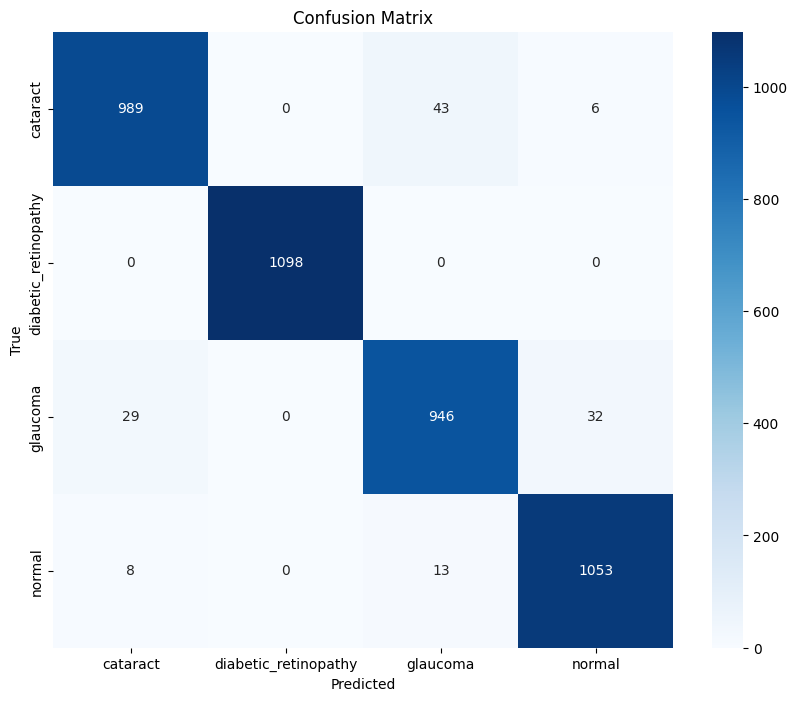

In [ ]:
import tensorflow as tf

# === Define test dataset path ===
test_dir = '/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset'

# === Load test dataset ===
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=False  # important for consistent true labels
)
import keras
keras.config.enable_unsafe_deserialization()


# === Load the model ===
model = tf.keras.models.load_model("fine_tuned_cnn_bilstm_se_mobilenetv2.keras", compile=False)

# === Evaluate function (from earlier) ===
def evaluate_model_on_test_ds(model, test_ds):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, confusion_matrix

    class_names = test_ds.class_names
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    report_dict = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(report_dict).transpose()
    pd.options.display.float_format = '{:.7f}'.format
    print("\n🧾 Classification Report (7 Decimal Precision):\n")
    print(report_df)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# === Call the evaluation function ===
evaluate_model_on_test_ds(model, test_ds)
